# Exercise 1: Training Deep Neural Network on MNIST



First i want to take a look at the images in the MNIST dataset

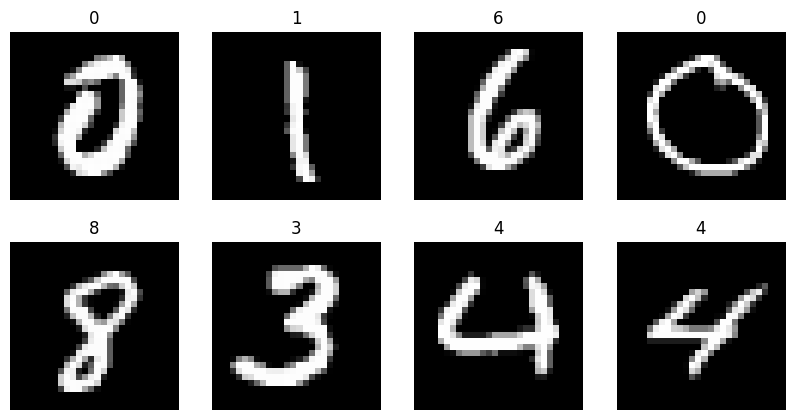

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Subset
torch.manual_seed(42)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_full = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_subset = Subset(mnist_full, range(1000))

indices = torch.randperm(len(mnist_subset))[:8]
images = torch.stack([mnist_subset[i][0] for i in indices])
labels = torch.tensor([mnist_subset[i][1] for i in indices])
plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].squeeze().numpy(), cmap='gray')
    plt.title(labels[i].item())
    plt.axis('off')
plt.show()


As we can see the dataset consits of pixelated images (28x28 pixel, black/white) of numbers with the correct labeling.

### Imports and set seed for reporducibility

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import numpy as np
import random

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data preperation and loading
Parameters given in excerise

In [3]:
tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])

train_full = datasets.MNIST('./data', train=True, download=True, transform=tfm)
test_full = datasets.MNIST('./data', train=False, download=True, transform=tfm)


train_ds, test_ds = Subset(train_full, range(1000)), Subset(test_full, range(200))
val_size = 200; train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

train_dl = DataLoader(train_ds, 32, True); val_dl = DataLoader(val_ds, 32); test_dl = DataLoader(test_ds, 32)


### Model definition and training

Epoch 01: Train 1.6048, Val 0.9551
Epoch 02: Train 0.6443, Val 0.6283
Epoch 03: Train 0.3703, Val 0.5664
Epoch 04: Train 0.2550, Val 0.5323
Epoch 05: Train 0.1754, Val 0.6083
Epoch 06: Train 0.1349, Val 0.6245
Epoch 07: Train 0.0950, Val 0.6376
Epoch 08: Train 0.0697, Val 0.6525
Epoch 09: Train 0.0530, Val 0.6916
Early stop.

Test Accuracy: 89.50%


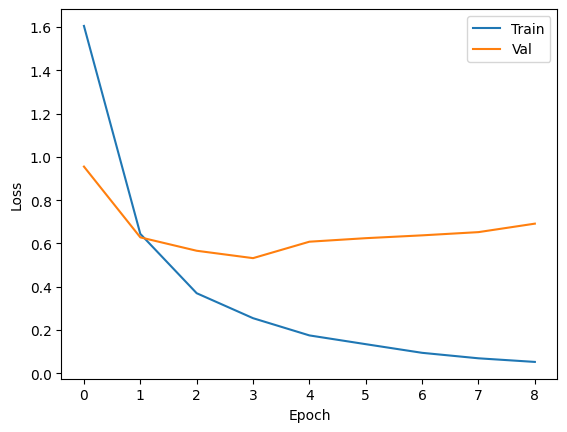

In [4]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64), nn.ELU(), 
            nn.Linear(64, 64), nn.ELU(),
            nn.Linear(64, 64), nn.ELU(),
            nn.Linear(64, 10)
        )
        for m in self.net:
            if isinstance(m, nn.Linear): nn.init.kaiming_normal_(m.weight)
    def forward(self, x): return self.net(x)

model = DNN().to(device)
opt = optim.NAdam(model.parameters(), lr=0.001) # learning rate 0.001
loss_fn = nn.CrossEntropyLoss() # Cross-entropy loss for multi-class classification


patience, best, wait = 5, 1e9, 0 # Early stopping parameters, patience set to 5
train_l, val_l = [], []
for e in range(50):                 # Max epochs set to 50
    model.train()
    running_loss = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = loss_fn(model(x), y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
    tl = running_loss / len(train_dl)

    model.eval(); val_loss = 0
    with torch.no_grad():
        for x, y in val_dl:
            val_loss += loss_fn(model(x.to(device)), y.to(device)).item()
    vl = val_loss / len(val_dl)
    train_l.append(tl); val_l.append(vl)
    print(f"Epoch {e+1:02d}: Train {tl:.4f}, Val {vl:.4f}")

    if vl < best: best, wait, best_w = vl, 0, model.state_dict().copy()
    else:
        wait += 1
        if wait >= patience: print("Early stop."); break

model.load_state_dict(best_w)

# --- Test ---
model.eval(); correct = total = 0
with torch.no_grad():
    for x, y in test_dl:
        p = model(x.to(device)).argmax(1)
        correct += (p.cpu() == y).sum().item(); total += y.size(0)
print(f"\nTest Accuracy: {100*correct/total:.2f}%")

# --- Plot ---
plt.plot(train_l, label='Train'); plt.plot(val_l, label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

## Step by step breakdown of the code 

### Data loading and preperation 

The ```tfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])``` part converts each MNIST image which are 28x28 pixels to a PyTourch tensor. (Tensor = multi-dimensional array)
. 

We also normalize the pixel values from [0,1] to [-1,1] using mean = 0.5, std = 0.5

The ```train_full``` and ```test_full``` donwloads MNISTs datasets and applies the transform. With train_full being the full training set (around 60000 samples) and test_full being the full test set (10000 samples). The samples sizes are shown on kaggle: 

![MNIST dataset size visualization](kaggle_size.PNG)

right under we declare```train_ds``` and ```train_ds``` only 1000 training and 200 test samples.

Later we declare the 1000 training samples into 800 for training and 200 for validation.

And to wrap up we wrap the datasets into DataLoaders for batch processing with a batch size of 32 with randomization on for training set. 
The DataLoader is a utility in PyTourch that allows us to easily iterate over a dataset in batches and allows for shuffling or parallel loading (multiple CPU workers to load data efficiently)







## Model definition
We define a class for the Deep Neural Network where we use Flatten() to convert each 28x28 image to a 784 lentght vector. (as the exercise requested), with 3 hidden layers each with 64 neurons and ELU (Exoibebtual Linear Unit) activation  (ELU used in NN to introduce non-linearity while helping with faster and more stable training compared to other functions such as ReLU).

The output layer has 10 neurons, as requested by the exercise. 

Since im running this notebook locally on my Laptop i have it set to run "model = DNN().to(device)" , which creates the model and moves to GPU if possible. (CPU otherwise)


## Training setup 
Exercise asked for:  Optimizer: Nadam and learning rate = 0.001, loss=sparse categorical crossentropy

So we declare ```opt = optim.NAdam(..., lr=0.001)``` for the NAdam optimizer with the learning rate of 0.001 and ```loss_fn = nn.CrossEntropyLoss()``` for the crossentropy loss declaration. 

Now what does this mean you might ask? (im the one asking) 
NAdam (Nesterov-accelerated Adaptive Moment Estimation) is an optimizer that combines both Adam and Nesterov momentum. Adam using adaptive learning rates using first (mean) and second (variance) moments of gradients, wholst Nesterov has more of a lookahead approch that imrpoves convergence by considering the gradient at the predicted next position. (Looks at next rather than the current one)

CrossEntropyLoss is a loss function for multi-classification that tells the model how wrong its predicted class probailities are and is used to update weights during training.  